<center>
<font size="6"><b>Introduction to Portfolio Optimization</b></font>
</center>

<br>

<center>
<font size="3"><b>Piotr Lipiński</b></font>
<br>
Computational Intelligence Research Group, Institute of Computer Science, University of Wroclaw, Poland
<br>
lipinski@cs.uni.wroc.pl
</center>

## Abstract:

This notebook illustrates the concept of portfolio optimization in the context of the financial time series from the Warsaw Stock Exchange.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import datetime
# import time
import zipfile

% matplotlib inline

import plotly.offline as py
import plotly.figure_factory as ff
import plotly.graph_objs as go

py.init_notebook_mode(connected=True)

py_config = {'displayModeBar': False, 'showLink': False, 'editable': False}

from ipywidgets import interact, interactive, fixed, interact_manual, widgets

In [2]:
STOCK_QUOTATIONS_ARCHIVE_FILE_NAME = 'D:/_____BOSSA_____/2018.05.14/mstall.zip'
STOCK_NAMES_FILE_NAME = 'D:/_____BOSSA_____/2015.11.05//WIG20.txt'

In [3]:
def load_stock_quotations(stock_names, filename):
    s = {}
    with zipfile.ZipFile(filename) as z:
        for stock_name in stock_names:
            with z.open(stock_name + '.mst') as f:
                s[stock_name] = pd.read_csv(f, index_col='<DTYYYYMMDD>', parse_dates=True)[['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<VOL>']]
                s[stock_name].index.rename('time', inplace=True)
                s[stock_name].rename(columns={'<OPEN>':'open', '<HIGH>':'high', '<LOW>':'low', '<CLOSE>':'close', '<VOL>':'volume'}, inplace=True)
    return pd.concat(s.values(), keys=s.keys(), axis=1)

## 1. Notowania spółek giełdowych

In [4]:
stock_names = pd.read_csv(STOCK_NAMES_FILE_NAME, index_col=0, names=['stock name']).index.values
stock_names.sort()
number_of_stocks = len(stock_names)

In [5]:
stock_quotations = load_stock_quotations(stock_names, STOCK_QUOTATIONS_ARCHIVE_FILE_NAME)
stock_quotations.fillna(method='ffill', inplace=True)
stock_quotations.tail()

ALIOR                                ASSECOPOL                \
             open   high    low  close    volume      open   high    low   
time                                                                       
2018-05-08  67.95  68.05  65.70  66.05  420855.0     44.60  44.84  44.22   
2018-05-09  66.10  68.55  65.90  68.30  420927.0     44.30  45.00  44.30   
2018-05-10  69.90  73.50  69.20  72.55  521518.0     44.98  45.00  44.68   
2018-05-11  72.30  73.45  72.00  72.80  360528.0     44.98  45.28  44.78   
2018-05-14  72.80  73.05  72.35  72.80  156323.0     45.16  45.30  44.80   

                               ...     SYNTHOS                              \
            close    volume    ...        open  high   low close    volume   
time                           ...                                           
2018-05-08  44.48   57018.0    ...         4.9  4.91  4.88  4.89  267394.0   
2018-05-09  45.00   47211.0    ...         4.9  4.91  4.88  4.89  267394.0   
2018-05-10  45.00   31980.0    ...         4.9  4.91  4.88  4.89  267394.0   
2018-05-11  44.84  106236.0    ...         4.9  4.91  4.88  4.89  267394.0   
2018-05-14  44.94   33078.0    ...         4.9  4.91  4.88  4.89  267394.0   

           TAURONPE                               
               open  high   low close     volume  
time                                              
2018-05-08     2.28  2.29  2.23  2.25  6635586.0  
2018-05-09     2.26  2.35  2.25  2.35  5186793.0  
2018-05-10     2.34  2.44  2.34  2.44  6516527.0  
2018-05-11     2.44  2.44  2.38  2.44  3747375.0  
2018-05-14     2.44  2.45  2.35  2.35  4641902.0  

[5 rows x 100 columns]

In [6]:
@interact(stock_name=stock_names)
def __plot_close_price(stock_name):
    ts = stock_quotations[stock_name]['close'].dropna()

    s_price = go.Scatter(
        x = ts.index.date,
        y = ts.data,
        name = stock_name,
        opacity = 0.75
    )
    data = go.Data([s_price])

    layout = go.Layout(
        title = stock_name,
        xaxis = dict(title='time'),
        yaxis = dict(title='price'),
        showlegend = False,
        legend = dict(orientation="h")
    )

    figure = go.Figure(data=data, layout=layout)

    py.iplot(figure, config=py_config)

interactive(children=(Dropdown(description='stock_name', options=('ALIOR', 'ASSECOPOL', 'BOGDANKA', 'BZWBK', 'EUROCASH', 'JSW', 'KERNEL', 'KGHM', 'LOTOS', 'LPP', 'MBANK', 'ORANGEPL', 'PEKAO', 'PGE', 'PGNIG', 'PKNORLEN', 'PKOBP', 'PZU', 'SYNTHOS', 'TAURONPE'), value='ALIOR'), Output()), _dom_classes=('widget-interact',))

## 2. Stopy zwrotu spółek giełdowych

Rozpatrujemy $d$ spółek giełdowych, $\mathcal{A}_1, \mathcal{A}_2, \ldots, \mathcal{A}_d$. Niech $v^i_t$ oznacza wartość akcji spółki $\mathcal{A}_i$ w dniu $t$ (dla celów obliczeniowych, przyjmujemy, że wartość akcji jest określana przez cenę zamknięcia). _Stopą zwrotu_ spółki $\mathcal{A}_i$ w dniu $t$ nazywamy $$r^i_t = \frac{v^i_t - v^i_{t-1}}{v^i_{t-1}}.$$

Niech $t_0$ będzie ustalonym przyszłym dniem. Zakładamy w związku z tym, że nie mamy informacji o notowaniach spółek giełdowych w dniu $t_0$, ale znamy notowania z dni poprzednich. Stopę zwrotu spółki $\mathcal{A}_i$ w dniu $t_0$ traktujemy więc jako zmienną losową, oznaczmy ją przez $R_i$, i możemy określić oczekiwaną stopę zwrotu $\mathbb{E}[R_i]$ oraz wariancję  stopy zwrotu $\mathbb{Var}[R_i]$ estymując je na okresie ostatnich $\Delta t$ dni, czyli na okresie $[t_0 - \Delta t, t_0 - 1]$. Analogicznie, oznaczając przez $\mathbf{R} = (R_1, R_2, \ldots, R_d)^T$ wektor losowy stóp zwrotu wszystkich rozpatrywanych spółek, możemy określić kowariancje $\mathbb{Cov}[\mathbf{R}]$ i korelacje $\mathbb{Corr}[\mathbf{R}]$ stóp zwrotu. Zatem:

- oczekiwaną stopę zwrotu $\mathbb{E}[R_i]$ spółki $\mathcal{A}_i$ w dniu $t_0$ definiujemy jako średnią stopą zwrotu z ostatnich $\Delta t$ dni, czyli z okresu $[t_0 - \Delta t, t_0 - 1]$,

- wariancję $\mathbb{Var}[R]$ spółki $\mathcal{A}_i$ w dniu $t_0$ definiujemy jako wariancję na ostatnich $\Delta t$ dniach, czyli na okresie $[t_0 - \Delta t, t_0 - 1]$,

- zależności między spółkami w dniu $t_0$ określamy przez kowariancję/korelację ich stóp zwrotu na ostatnich $\Delta t$ dniach, czyli na okresie $[t_0 - \Delta t, t_0 - 1]$.

<hr>
<b>UWAGA:</b> Przez <i>dzień</i> rozumiem tutaj <i>dzień roboczy</i>, a nie <i>dzień kalendarzowy</i>. Prowadzi to do pewnych nieścisłości (stopa zwrotu dla poniedziałku to de facto trzydniowa stopa zwrotu), bo tak liczone stopy zwrotu różnią się od stóp zwrotu liczonych zazwyczaj dla instrumentów pozbawionych ryzyka, m.in. lokat bankowych, gdzie oprocentowanie liczy się dla wszystkich dni kalendarzowych.

<hr>
Poniższe przykładowe obliczenia ilustrują estymowanie oczekiwanej stopy zwrotu i wariancji dla ostatniego dnia zarejestrowanych notowań.

In [7]:
delta_t = 90
stock_returns = stock_quotations.xs('close', level=1, axis=1).pct_change()
stock_returns_m = stock_returns[-delta_t-1:-1].mean()
stock_returns_s = stock_returns[-delta_t-1:-1].std()
stock_covariances = stock_returns[-delta_t-1:-1].cov()
stock_correlations = stock_returns[-delta_t-1:-1].corr()

### 2.1. Oczekiwana stopa zwrotu i ryzyko (określone przez wariancję stopy zwrotu) rozpatrywanych spółek

In [8]:
b_stocks = go.Bar(
    x = stock_returns_m.index,
    y = 100.0 * stock_returns_m,
    name = 'WIG20',
    opacity = 0.75
)
data = go.Data([b_stocks])

layout = go.Layout(
    title = 'expected return rate',
    xaxis = dict(title='', zeroline=False),
    yaxis = dict(title='expected return rate', zeroline=True),
    showlegend = False,
    legend = dict(orientation="h")
)

figure = go.Figure(data=data, layout=layout)

py.iplot(figure, config=py_config)

In [9]:
b_stocks = go.Bar(
    x = stock_returns_s.index,
    y = stock_returns_s**2,
    name = 'WIG20',
    opacity = 0.75
)
data = go.Data([b_stocks])

layout = go.Layout(
    title = 'variance of return rate',
    xaxis = dict(title='', zeroline=False),
    yaxis = dict(title='variance of return rate', zeroline=True),
    showlegend = False,
    legend = dict(orientation="h")
)

figure = go.Figure(data=data, layout=layout)

py.iplot(figure, config=py_config)

### 2.2. Korelacja stóp zwrotu rozpatrywanych spółek

In [10]:
h_correlations = go.Heatmap(
    z = stock_correlations.values,
    x = stock_correlations.columns.values,
    y = stock_correlations.columns.values,
    colorscale = 'Jet',
    name = 'WIG20',
    opacity = 0.75
)
data = go.Data([h_correlations])

layout = go.Layout(
    title = 'correlation of return rates',
    xaxis = dict(title='', zeroline=False),
    yaxis = dict(title='', zeroline=False),
    showlegend = False,
    legend = dict(orientation="h"),
    height=800,
    width=800
)

figure = go.Figure(data=data, layout=layout)

py.iplot(figure, config=py_config)

### 2.3. Spółki dominujące, zdominowane i niezdominowane

Zastanawiając się w którą spółkę giełdową zainwestować kapitał, rozważamy dwa parametry: oczekiwaną stopę zwrotu inwestycji oraz ryzyko inwestycji (definiowane przez wariancję stopy zwrotu). Rozpatrując zbiór spółek giełdowych, można wprowadzić pojęcia _spółki dominującej_ i _spółki zdominowanej_ w następujący sposób:

- Mówimy, że spółka giełdowa $\mathcal{A}$ dominuje spółkę giełdową $\mathcal{B}$, jeżeli oczekiwana stopa zwrotu spółki $\mathcal{A}$ jest nie niższa niż spółki $\mathcal{B}$ oraz ryzyko spółki $\mathcal{A}$ jest niższe niż ryzyko spółki $\mathcal{B}$ .
- Spółka $\mathcal{B}$ jest spółką zdominowaną, jeśli istnieje spółka $\mathcal{A}$, która ją dominuje.
- Spółka $\mathcal{B}$ jest spółką niezdominowaną, jeśli nie istnieje spółka $\mathcal{A}$, która ją dominuje.

In [11]:
is_dominated = np.zeros(stock_returns_m.size)
for i in range(stock_returns_m.size):
    for j in range(stock_returns_m.size):
        if (i != j) and (stock_returns_m[i] <= stock_returns_m[j]) and (stock_returns_s[i] > stock_returns_s[j]):
            is_dominated[i] = 1
            break

s_dominated = go.Scatter(
    x = stock_returns_s[is_dominated == 1],
    y = 100.0 * stock_returns_m[is_dominated == 1],
    text=stock_returns_m.index.values,
    name = 'dominated',
    mode = 'markers',
    marker = dict(
        size = 8,
        color = 'rgb(128, 128, 128)',
        line = dict(
            color = 'rgb(0, 0, 0)',
            width = 1.5
        )
    ),
    hoverinfo='text',
    showlegend = True,
    opacity = 0.75
)
s_non_dominated = go.Scatter(
    x = stock_returns_s[is_dominated == 0],
    y = 100.0 * stock_returns_m[is_dominated == 0],
    text=stock_returns_m.index.values,
    name = 'non-dominated',
    mode = 'markers',
    marker = dict(
        size = 18,
        color = 'rgb(128, 0, 0)',
        line = dict(
            color = 'rgb(0, 0, 0)',
            width = 1.5
        )
    ),
    hoverinfo='text',
    showlegend = True,
    opacity = 0.75
)
data = go.Data([s_dominated, s_non_dominated])

layout = go.Layout(
    title = 'WIG20',
    xaxis = dict(title='standard deviation of return rate', zeroline=False),
    yaxis = dict(title='expected return rate', zeroline=False),
    showlegend = True,
    legend = dict(orientation="h")
)

figure = go.Figure(data=data, layout=layout)

py.iplot(figure, config=py_config)

## 3. Teoria portfela Markowitza

Zamiast zastanawiać się w którą spółkę giełdową zainwestować cały kapitał, można zastanawiać się jak podzielić rozpatrywany kapitał na części i zainwestować je w poszczególne spółki (stworzyć _portfel_ inwestycji).

### 3.1. Wprowadzenie

Niech $\mathbf{R} = (R_1, R_2, \ldots, R_d)^T$ oznacza wektor losowy stóp zwrotu wszystkich rozpatrywanych spółek.

Niech $\boldsymbol{\mu} = (\mu_1, \mu_2, \ldots, \mu_d)^T = \mathbb{E}[\mathbf{R}] \in \mathbb{R}^d$ oznacza wektor oczekiwanych stóp zwrotu rozpatrywanych spółek.

Niech $\boldsymbol{\Sigma} = \mathbb{Cov}[\mathbf{R}] \in \mathbb{R}^{d \times d}$ oznacza macierz kowariancji stóp zwrotu rozpatrywanych spółek.

Zakładamy, że rozpatrywane spółki są instrumentami obarczonymi ryzykiem, czyli wariancja ich stóp zwrotu jest niezerowa (dokładniej: zakładamy, że macierz kowariancji $\boldsymbol{\Sigma}$ jest dodatnio określona - skąd wynika, że jest macierzą odwracalną).

_Portfelem_ nazywamy wektor $\mathbf{p} = (p_1, p_2, \ldots, p_d)^T \in \mathbb{R}^d$, taki że $\sum_{i=1}^d p_i = 1$, który definiuje rozbicie kapitału na części do zainwestowania w poszczególne spółki ($p_i$ to wielkość kapitału do zainwestowania w spółkę $\mathcal{A}_i$).

Stopa zwrotu portfela $\mathbf{p}$ jest więc zmienną losową $R_\mathbf{p} = \mathbf{p}^T \mathbf{R}$.

Oczekiwana stopa zwrotu portfela wynosi zatem $\mathbb{E}[R_\mathbf{p}] = \mathbb{E}[\mathbf{p}^T \mathbf{R}] = \mathbf{p}^T \mathbb{E}[\mathbf{R}] = \mathbf{p}^T \boldsymbol{\mu}$.

Ryzyko portfela, określone przez wariancję jego stopy zwrotu, wynosi zatem $\mathbb{Var}[R_\mathbf{p}] = \mathbb{Var}[\mathbf{p}^T \mathbf{R}] = \mathbf{p}^T \mathbb{Cov}[\mathbf{R}] \mathbf{p} = \mathbf{p}^T \boldsymbol{\Sigma} \mathbf{p}$.

<div style="background-color:rgba(0, 0, 0, 0.15)">
<b>UWAGA</b>: Powyższe podejście teoretyczne nie pokrywa się z podejściem obliczeniowym (wartość oczekiwana i wariancja stopy zwrotu portfela estymowana na podstawie jego wartości w ustalonym okresie nie pokrywają się z wartościami liczonymi według powyższych wzorów).

Pozornie, dla ustalonego dnia $t_0$, oczekiwaną stopę zwrotu portfela (i analogicznie jej wariancję), można byłoby określić estymując je na okresie ostatnich $\Delta t$ dni, czyli na okresie $[t_0 - \Delta t + 1, t_0]$.

Portfel definuje jaka część całkowitego kapitału (domyślnie równego 1) jest inwestowana w poszczególne spółki: w $i$-tą spółkę inwestowane jest $p_i$, czyli kupowane jest $\frac{p_i}{v^i_{t_0}}$ akcji tej spółki. Zatem, całkowita wartość takiego portfela w dniu $t$ wynosiła $$\sum_{i=1}^d \frac{p_i}{v^i_{t_0}} v^i_t,$$ czyli stopa zwrotu takiego portfela w dniu $t$ wynosiła $$\frac{\sum_{i=1}^d \frac{p_i}{v^i_{t_0}} v^i_t - \sum_{i=1}^d \frac{p_i}{v^i_{t_0}} v^i_{t-1}}{\sum_{i=1}^d \frac{p_i}{v^i_{t_0}} v^i_{t-1}} = \frac{\sum_{i=1}^d \frac{p_i}{v^i_{t_0}} (v^i_t - v^i_{t-1})}{\sum_{i=1}^d \frac{p_i}{v^i_{t_0}} v^i_{t-1}} = \frac{\sum_{i=1}^d p_i r^i_t \frac{v^i_{t-1}}{v^i_{t_0}}}{\sum_{i=1}^d p_i \frac{v^i_{t-1}}{v^i_{t_0}}} \approx \frac{\sum_{i=1}^d p_i r^i_t}{\sum_{i=1}^d p_i} = \sum_{i=1}^d p_i r^i_t,$$ o ile $\frac{v^i_{t-1}}{v^i_{t_0}}$ jest bliskie $1$.

Jeśli $t$ byłoby równe $t_0 + 1$, to oczywiście równość zachodziłaby. W przeciwnym przypadku możemy otrzymać rozbieżność między bezpośrednio estymowaną oczekiwaną stopą zwrotu portfela, a oczekiwaną stopą zwrotu portfela wyliczoną z modelu zawierającego estymowane statystyki stóp zwrotu rozpatrywanych spółek.

Rozbieżność ta wynika z faktu, że próbujemy przekształcić portfel wyrażający procentowy udział poszczególnych spółek w całkowitym kapitale portfela na liczbę akcji poszczególnych spółek, a ze względu na zmiany cen akcji w czasie, ustalenie konkretnej liczby akcji w wybranym dniu $t_0$ może powodować zmiany procentowego udziału poszczególnych spółek w całkowitym kapitale portfela w czasie. Innymi słowy, w rozpatrywanej wyżej estymacji, w dniach $t \neq t_0$ analizowaliśmy portfel nie będący portfelem $\mathbf{p}$!
</div>

### 3.2. Optymalizacja portfela

_Portfel optymalny_ to portfel minimalizujący ryzyko dla ustalonej oczekiwanej stopy zwrotu. Można go formalnie określić jako rozwiązanie problemu optymalizacji funkcji
$$\frac{1}{2} \mathbf{p}^T \boldsymbol{\Sigma} \mathbf{p}$$ z ograniczeniami $$\mathbf{p}^T \boldsymbol{\mu} = e,
\quad
\mathbf{p}^T \mathbf{1} = 1,$$
gdzie $e$ jest ustaloną oczekiwaną stopą zwrotu portfela.

Stosując metodę mnożników Lagrange'a, można rozwiązać ten problem analitycznie otrzymując rozwiązanie [1]:
$$\mathbf{p} = \frac{1}{D} ((e C - A) \boldsymbol{\Sigma}^{-1} \boldsymbol{\mu} + (B - e A) \boldsymbol{\Sigma}^{-1} \mathbf{1}) = \frac{1}{D} (B \boldsymbol{\Sigma}^{-1} \mathbf{1} - A \boldsymbol{\Sigma}^{-1} \boldsymbol{\mu}) +
e \frac{1}{D} ((C \boldsymbol{\Sigma}^{-1} \boldsymbol{\mu} - A \boldsymbol{\Sigma}^{-1} \mathbf{1}),$$
gdzie
$$A = \boldsymbol{\mu}^T \boldsymbol{\Sigma}^{-1} \mathbf{1}, \qquad
B = \boldsymbol{\mu}^T \boldsymbol{\Sigma}^{-1} \boldsymbol{\mu}, \qquad
C = \mathbf{1}^T \boldsymbol{\Sigma}^{-1} \mathbf{1}, \qquad
D = B C - A^2.$$

Rozwiązania problemu optymalizacji portfela można przedstawić jako
$$\mathbf{p} = \mathbf{p}_1 + e \mathbf{p}_2,$$
gdzie
$$\mathbf{p}_1 = \frac{1}{D} (B \boldsymbol{\Sigma}^{-1} \mathbf{1} - A \boldsymbol{\Sigma}^{-1} \boldsymbol{\mu}),
\qquad
\mathbf{p}_2 = \frac{1}{D} ((C \boldsymbol{\Sigma}^{-1} \boldsymbol{\mu} - A \boldsymbol{\Sigma}^{-1} \mathbf{1}).$$

In [12]:
d = stock_returns_m.size

Sinv = np.linalg.inv(stock_covariances)

A = stock_returns_m.T.dot(Sinv.dot(np.ones(d)))
B = stock_returns_m.T.dot(Sinv.dot(stock_returns_m))
C = np.ones(d).T.dot(Sinv.dot(np.ones(d)))
D = B * C - A**2

p1 = 1/D * (B * Sinv.dot(np.ones(d)) - A * Sinv.dot(stock_returns_m))
p2 = 1/D * (C * Sinv.dot(stock_returns_m) - A * Sinv.dot(np.ones(d)))

p = np.array([p1 + 0.0001 * i * p2 for i in range(1000)]).T

p_m = p.T.dot(stock_returns_m)
p_s = np.sqrt(np.diag(p.T.dot(stock_covariances.dot(p))))

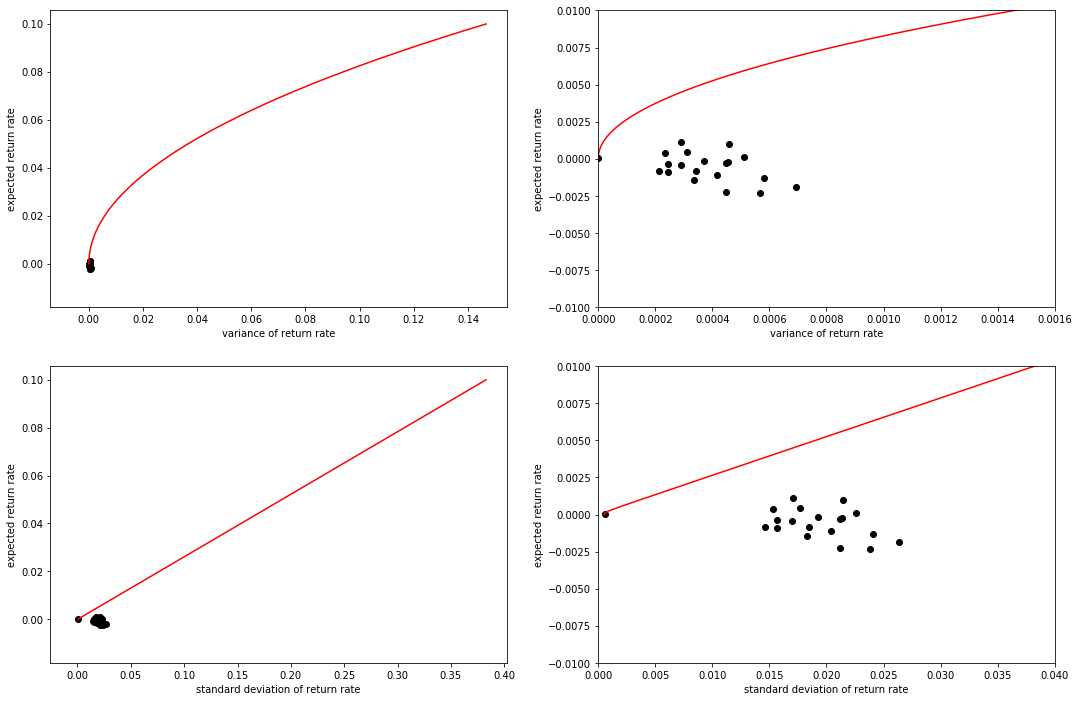

In [13]:
plt.figure(figsize=(18, 12))

plt.subplot(2, 2, 1)
plt.scatter(stock_returns_s**2, stock_returns_m, color='#000000')
plt.plot(p_s**2, p_m, '-r')
plt.xlabel('variance of return rate')
plt.ylabel('expected return rate')

plt.subplot(2, 2, 2)
plt.scatter(stock_returns_s**2, stock_returns_m, color='#000000')
plt.plot(p_s**2, p_m, '-r')
plt.xlim([0, 0.0016])
plt.ylim([-0.01, 0.01])
plt.xlabel('variance of return rate')
plt.ylabel('expected return rate')

plt.subplot(2, 2, 3)
plt.scatter(stock_returns_s, stock_returns_m, color='#000000')
plt.plot(p_s, p_m, '-r')
plt.xlabel('standard deviation of return rate')
plt.ylabel('expected return rate')

plt.subplot(2, 2, 4)
plt.scatter(stock_returns_s, stock_returns_m, color='#000000')
plt.plot(p_s, p_m, '-r')
plt.xlim([0, 0.04])
plt.ylim([-0.01, 0.01])
plt.xlabel('standard deviation of return rate')
plt.ylabel('expected return rate')

plt.show()

## 4. Teoria portfela w praktyce

W ostatnich latach powstaje wiele rozszerzeń klasycznej teorii portfela, które często prowadzą do problemów optymalizacji wymagających złożonych algorytmów rozwiązywania. Wiele modeli wprowadza inne niż wariancja miary ryzyka (m.in. semiwariancja). Wiele modeli odrzuca też założenie o braku ograniczeń _krótkiej sprzedaży_ (ang. short sale), czyli możliwości posiadania ujemnej liczby akcji (w klasycznej teorii portfela dopuszcza się, że współrzędne $p_i$ portfela mogą być ujemne).

## References

[1] Markowitz, H., M., <a href='https://doi.org/10.2307/2975974'>Portfolio Selection</a>, <i>Journal of Finance<i>, vol.7, no.1, 1952, pp.77–91.